# Fraud Detection System - V1: Exploratory Data Analysis (EDA)

**Date:** 2026-01-24    
**Author:** *Luis Renteria Lezano*  
[LinkedIn](https://www.linkedin.com/in/renteria-luis) | [GitHub](https://github.com/renteria-luis)

## Executive Summary
- **Goal:** Understand the key factors influencing **fraudulent transactions** in credit card operations and prepare **clean, structured data** suitable for building **baseline and advanced classification models**. The focus is on **detecting anomalies**, **identifying patterns of fraud**, and creating a **robust dataset** that can support **machine learning algorithms** for **real-time fraud detection**. Special attention is given to the **highly imbalanced target class**, ensuring proper handling of **rare fraudulent cases** during model training and evaluation.
- **Source:** This analysis uses the Credit Card Fraud Detection dataset published on [Kaggle by MLG ULB](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data).
- **Data:** [`../data/raw/creditcard.csv`](../data/raw/creditcard.csv).
- **Target variable:** `Class`:
    - 0 = legitimate transaction
    - 1 = fraudulent transaction

## 1. Reproducibility & Environment Setup
- Pin versions in [`../requirements.txt`](../).
- Keep raw data immutable [`../data/raw/`](../data/raw/).

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

from sklearn.model_selection import train_test_split

sys.path.append('..')
from src.features import FeatureEngineering

# 1. Global Reproducibility
SEED = 42
np.random.seed(SEED)

# 2. Path Management
BASE_DIR = Path("..")
ASSETS_DIR = Path('../assets/figures')
DATA_RAW = BASE_DIR / "data" / "raw"
DATA_PROCESSED = BASE_DIR / "data" / "processed"
MODELS_DIR = BASE_DIR / "models"
MODELS_DIR = BASE_DIR / "models"

# 3. Plotting Style
sns.set_theme(style='whitegrid', context='notebook', palette='viridis')
plt.rcParams["figure.figsize"] = (10, 6)

# 4. Global Settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 2. Data Loading & Overview
### 2.1 Load Data

In [2]:
raw_file = DATA_RAW / "creditcard.csv"
df = pd.read_csv('../data/raw/creditcard.csv')

### 2.2 Dataset Shape & Info

In [3]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Columns: 31 entries, Time to Class
dtypes: float64(30), int64(1)
memory usage: 67.4 MB


### 1.3 First Rows Preview

In [4]:
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,0.091,-0.552,-0.618,-0.991,-0.311,1.468,-0.470,0.208,0.026,0.404,0.251,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,149.620,0
1,0.000,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,-0.167,1.613,1.065,0.489,-0.144,0.636,0.464,-0.115,-0.183,-0.146,-0.069,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,2.690,0
2,1.000,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,0.208,0.625,0.066,0.717,-0.166,2.346,-2.890,1.110,-0.121,-2.262,0.525,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,378.660,0


In [5]:
df.tail(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284804,172788.000,1.920,-0.301,-3.250,-0.558,2.631,3.031,-0.297,0.708,0.432,-0.485,0.412,0.063,-0.184,-0.511,1.329,0.141,0.314,0.396,-0.577,0.001,0.232,0.578,-0.038,0.640,0.266,-0.087,0.004,-0.027,67.880,0
284805,172788.000,-0.240,0.530,0.703,0.690,-0.378,0.624,-0.686,0.679,0.392,-0.399,-1.934,-0.963,-1.042,0.450,1.963,-0.609,0.510,1.114,2.898,0.127,0.265,0.800,-0.163,0.123,-0.569,0.547,0.109,0.105,10.000,0
284806,172792.000,-0.533,-0.190,0.703,-0.506,-0.013,-0.650,1.577,-0.415,0.486,-0.915,-1.040,-0.032,-0.188,-0.084,0.041,-0.303,-0.660,0.167,-0.256,0.383,0.261,0.643,0.377,0.009,-0.474,-0.818,-0.002,0.014,217.000,0


**Findings:**
- Features V1-V28 are PCA-transformed (anonymized for privacy purposes)
- Time: seconds elapsed since first transaction
- Amount: transaction value
- Class: 0 (legitimate) / 1 (fraud)

## 3. Data Quality Assessment
### 3.1 Missing Values

In [6]:
missing_per_col = df.isna().sum()

if missing_per_col.sum() > 0:
    missing_per_col[missing_per_col > 0].sort_values(ascending=False).head()
else:
    print('There are no missing values in the dataset.')

There are no missing values in the dataset.


### 3.2 Duplicates

In [7]:
duplicates = df.duplicated().sum()

if duplicates > 0:
    print(f'There are {duplicates} duplicated rows in the dataset.')
    df = df.drop_duplicates()
else:
    print('There are no duplicates in the dataset.')

There are 1081 duplicated rows in the dataset.


## 4. Target Variable Analysis (Class Imbalance)
### 4.1 Class Distribution

In [8]:
counts = df['Class'].value_counts()
percent = df['Class'].value_counts(normalize=True) * 100

summary = pd.DataFrame({
    'Count': counts,
    'Percentage': percent
}).reset_index()

summary.rename(columns={'index': 'Class'}, inplace=True)
summary

,Class,Count,Percentage
0,0,283253,99.833
1,1,473,0.167


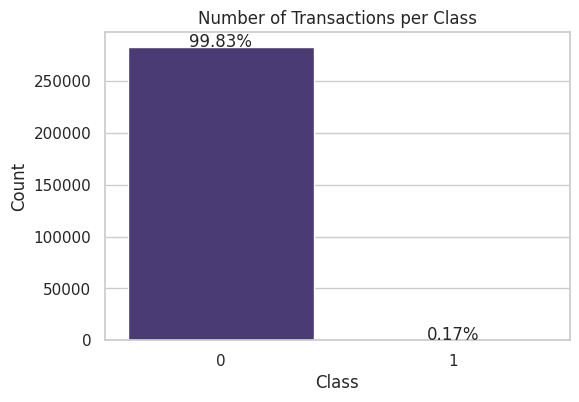

In [9]:
plt.figure(figsize=(6,4))
ax = sns.barplot(x='Class', y='Count', data=summary)
plt.title('Number of Transactions per Class')

for i, row in summary.iterrows():
    ax.text(i, row['Count'] + 100, f"{row['Percentage']:.2f}%", ha='center')

plt.show()

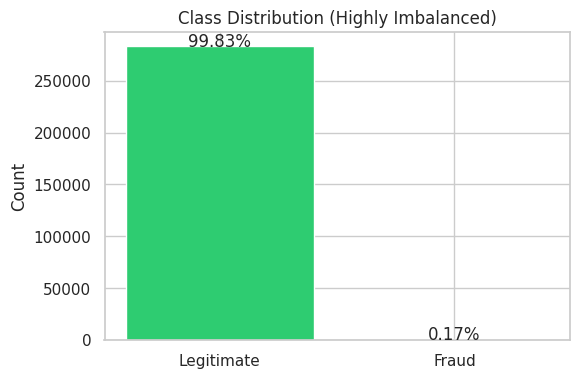

In [35]:
fig, ax = plt.subplots(figsize=(6,4))

class_counts = df['Class'].value_counts()
class_counts = class_counts.reindex([0,1])

ax.bar(['Legitimate', 'Fraud'], class_counts.values, color=['#2ecc71', '#e74c3c'])
ax.set_ylabel('Count')
ax.set_title('Class Distribution (Highly Imbalanced)')

for i, count in enumerate(class_counts.values):
    pct = 100 * count / class_counts.values.sum()
    ax.text(i, count + 100, f"{pct:.2f}%", ha='center')

plt.savefig(ASSETS_DIR / 'class_distribution.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

**Key Finding:**
- Class 0: 283,253 (99.83%)
- Class 1: 473 (0.17%)
- **Severe imbalance → will need SMOTE/class weights**

### 4.2 Imbalance Ratio

In [10]:
# imbalance_ratio = legitimate / fraud
print(f"For every fraudulent transaction, there are {int(summary.loc[0, 'Count'] / summary.loc[1, 'Count'])} legitimate transactions.")

For every fraudulent transaction, there are 598 legitimate transactions.


**Implication for modeling:**
- Accuracy is useless metric (99.8% by predicting all 0)
- Focus on Precision, Recall, F1, ROC-AUC, AUPRC
- Stratified split essential

## 5. Statistical Analysis
### 5.1 Summary

In [11]:
df.describe().loc[:, ['Time', 'Amount']]

,Time,Amount
count,283726.000,283726.000
mean,94811.078,88.473
std,47481.048,250.399
min,0.000,0.000
25%,54204.750,5.600
50%,84692.500,22.000
75%,139298.000,77.510
max,172792.000,25691.160


**Observations:**
- Time: [0, 172792] seconds (~48 hours of data)
- Amount: highly right-skewed (mean << max)
- V1-V28: already standardized (PCA result)

### 5.2 Feature Types Classification

In [12]:
num_cols = df.select_dtypes(['int64', 'float64', 'number']).columns
cat_cols = df.select_dtypes(['object', 'category', 'string']).columns
bool_cols = df.select_dtypes(['bool']).columns

print(f"Continuous Numerical features: {', '.join(list(num_cols))}")
print(f"Categorical features: {', '.join(list(cat_cols))}")
print(f"Boolean/Binary: Class (target)")

Continuous Numerical features: Time, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, Amount, Class
Categorical features: 
Boolean/Binary: Class (target)


**Note:** Will create categorical features in FE (hour bins, amount ranges)

## 6. Feature Analysis
### 6.1 Time Feature

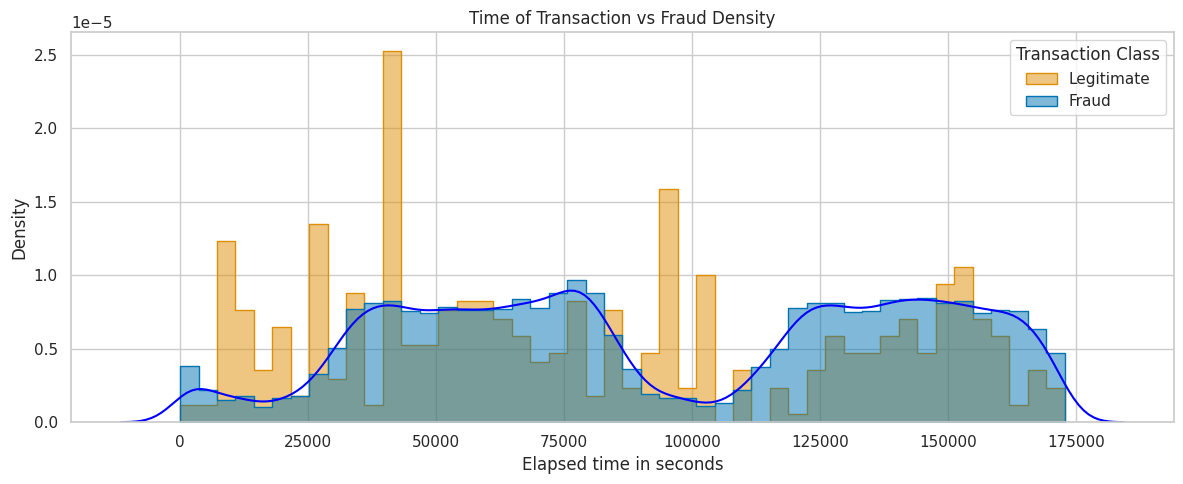

In [34]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=df, x='Time', hue='Class', element='step', stat='density', common_norm=False, bins=48, alpha=0.5, palette='colorblind')
sns.kdeplot(data=df[df['Class']==0], x='Time', color='blue')
ax.set(title='Time of Transaction vs Fraud Density', xlabel='Elapsed time in seconds', ylabel='Density')
ax.legend(title='Transaction Class', labels=['Legitimate', 'Fraud'])
plt.tight_layout()
plt.savefig(ASSETS_DIR / 'time_distribution.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

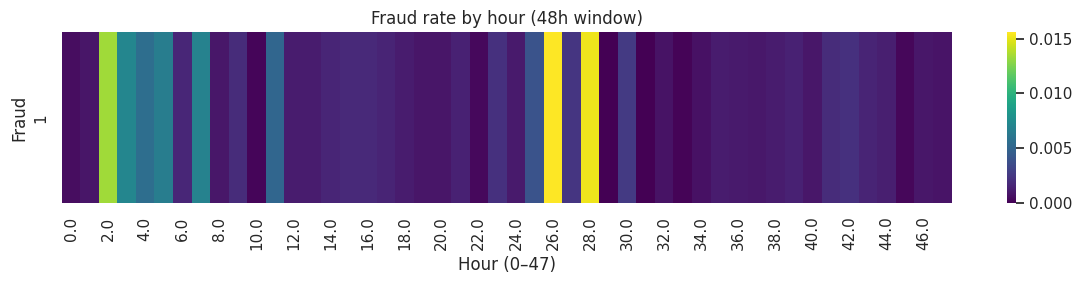

In [14]:
hour_48 = df['Time'] // 3600
heatmap_data = pd.crosstab(hour_48, df['Class'], normalize='index')

fig, ax = plt.subplots(figsize=(12, 3))
sns.heatmap(heatmap_data[[1]].T, cmap='viridis', annot=False, ax=ax)
ax.set(title='Fraud rate by hour (48h window)', xlabel='Hour (0–47)', ylabel='Fraud')
plt.tight_layout()
plt.show()

**Insights**:  
- The "blue line peaks" represent the hours of commercial activity (day/afternoon), and the valleys represent the rest period (early morning). It is standard human behavior. Transaction volume drops between 2:00 AM and 6:00 AM.  
- Although there is a peak of fraudulent transactions at around 40,000 seconds (day), the graph suggests that fraud is relatively more common during the early morning (valleys) between 10,000–20,000 seconds and 90,000–100,000 seconds.  
- **Potential FE:** hour_of_day, is_night using sine/cosine under this logical assumption (T = 0 → 00:00)

### 6.2 Amount Feature

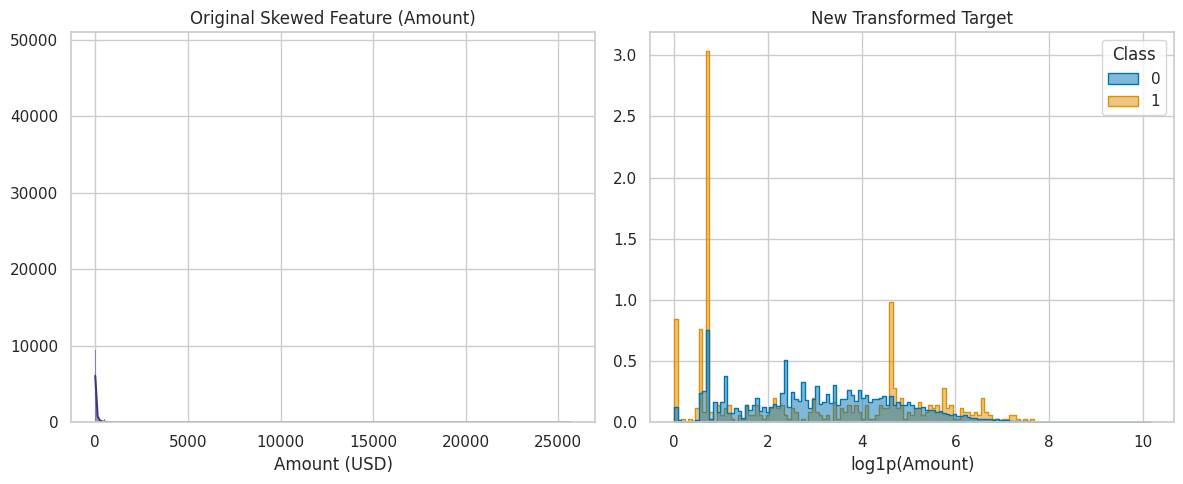

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(data=df, x='Amount', kde=True, ax=ax[0])  # Right-skewed feature
sns.histplot(data=df, 
             x=np.log1p(df['Amount']), 
             ax=ax[1], hue='Class', 
             element='step', 
             stat='density', 
             common_norm=False, 
             alpha=0.5, 
             palette='colorblind')  # Transformed feature

ax[0].set(title='Original Skewed Feature (Amount)', xlabel='Amount (USD)', ylabel='')
ax[1].set(title='New Transformed Target', xlabel='log1p(Amount)', ylabel='')

plt.tight_layout()
plt.show()

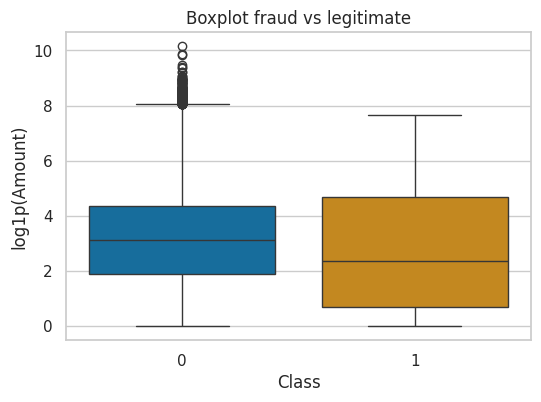

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=df, x='Class', y=df['Amount'].pipe(lambda x: np.log1p(x)), hue='Class', palette='colorblind', legend=False)
ax.set(title='Boxplot fraud vs legitimate', xlabel='Class', ylabel='log1p(Amount)')
plt.show()

**Insights**:  
- Class 1 median << Class 0 median.  
- Class 0 has many high-value outliers (Amount > 8).  
- XGBoost may flag legitimate high-value transactions as fraud.  
- Peak ≈ 0.7 → Amount ≈ 1 USD (e^0.7−1 ≈ 1.01).  
  - Typical carding/trialing behavior: minimal charge to test card.  
- Peak ≈ 4.5 → Amount ≈ 89 USD.  
  - Sweet spot: profitable but under automatic alert limits.

### 5.3 PCA Features (V1 - V28) & Top Discriminative V Features
A variable is discriminative if its values allow a clear separation between class 0 and class 1.  
The higher the K-S statistic, the more distinct the distributions between classes → the better the discriminative power.

Top 10 discriminative features: ['V14', 'V10', 'V12', 'V4', 'V11', 'V17', 'V3', 'V16', 'V7', 'V2']


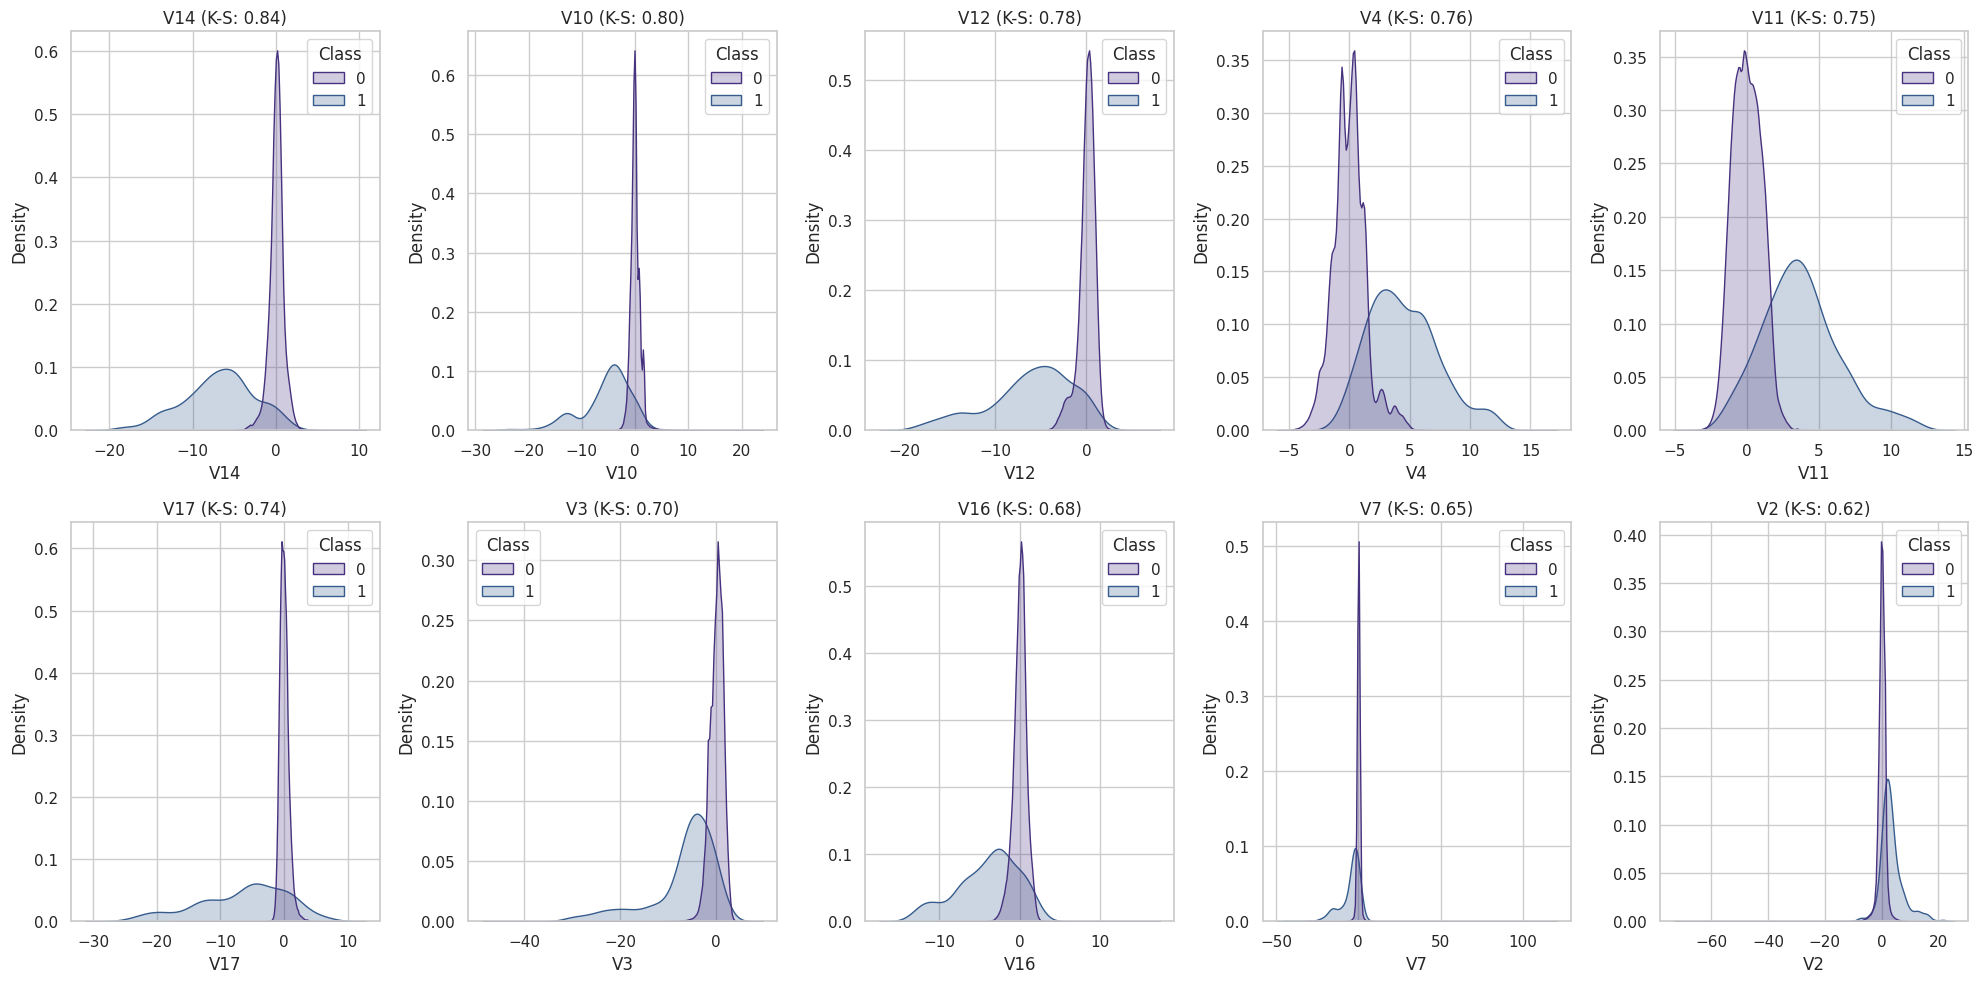

In [17]:
# 1. Identify the most discriminative variables using the K-S Test
v_features = [f'V{i}' for i in range(1, 29)]
ks_stats = {}

for col in v_features:
    stat, _ = ks_2samp(df[df['Class'] == 0][col], df[df['Class'] == 1][col])
    ks_stats[col] = stat

# Select Top 10
top_10_features = sorted(ks_stats, key=ks_stats.get, reverse=True)[:10]
print(f"Top 10 discriminative features: {top_10_features}")

# 2. Visualization: Density Plots
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(top_10_features):
    sns.kdeplot(data=df, x=col, hue='Class', common_norm=False, ax=axes[i], fill=True)
    axes[i].set_title(f'{col} (K-S: {ks_stats[col]:.2f})')

plt.tight_layout()
plt.show()

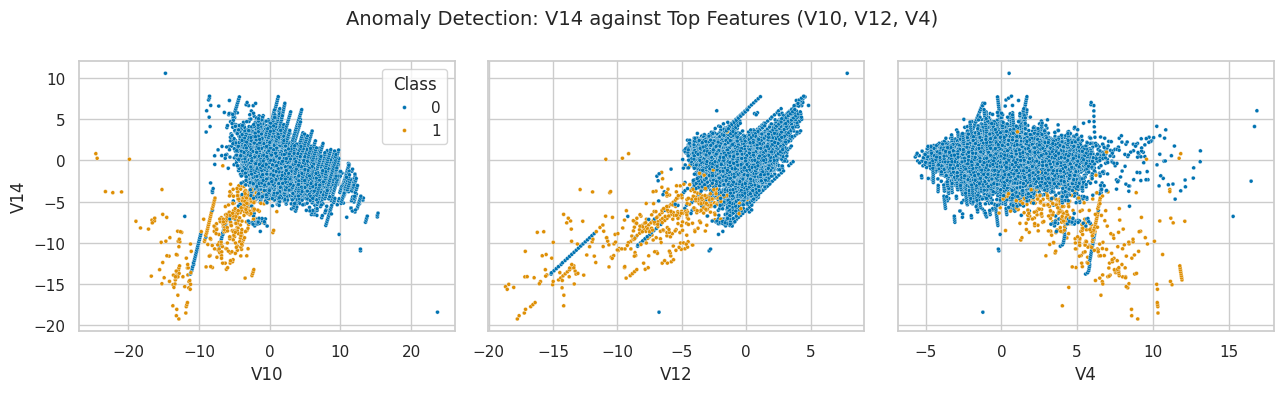

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4), sharey=True)

sns.scatterplot(data=df, x='V10', y='V14', hue='Class', s=8, palette='colorblind', ax=axes[0])
axes[0].set_xlabel('V10')
axes[0].set_ylabel('V14')

sns.scatterplot(data=df, x='V12', y='V14', hue='Class', s=8, palette='colorblind', ax=axes[1], legend=False)
axes[1].set_xlabel('V12')
axes[1].set_ylabel('V14')

sns.scatterplot(data=df, x='V4', y='V14', hue='Class', s=8, palette='colorblind', ax=axes[2], legend=False)
axes[2].set_xlabel('V4')
axes[2].set_ylabel('V14')

fig.suptitle('Anomaly Detection: V14 against Top Features (V10, V12, V4)', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.85)

plt.savefig(ASSETS_DIR / 'scatter_v14_vs_top3.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

**Insight:** V14, V10, V12, V4, V11, V17, V3, V16, V7, V2 show strong separation, being V14 the most discriminative.

## 7. Correlation Analysis
### 7.1 Correlation Matrix

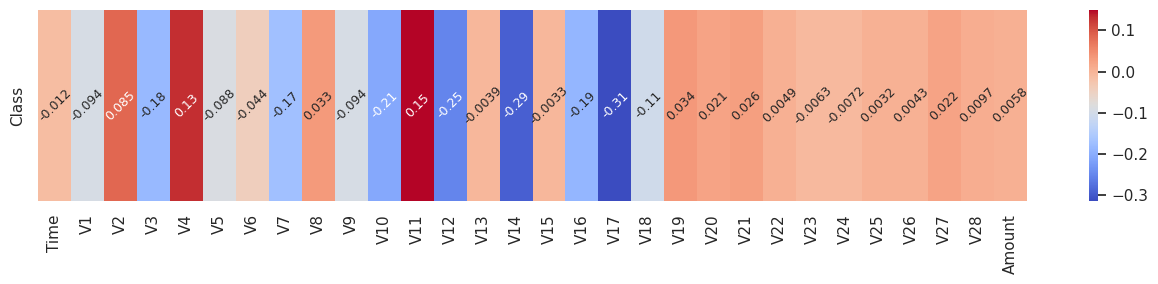

In [19]:
# Heatmap of all features
# Focus on correlations with Class
fig, ax = plt.subplots(figsize=(13, 3))
corr = df.select_dtypes(['number', 'float64', 'int64']).corr().loc[['Class'], 'Time':'Amount']
sns.heatmap(data=corr, cmap='coolwarm', annot=True, annot_kws={'rotation': 45, 'size': 9})
plt.tight_layout()
plt.show()

In [20]:
np.abs(corr.loc[:, 'V1':'V28'].T).sort_values(by='Class', ascending=False).head(5)

,Class
V17,0.313
V14,0.293
V12,0.251
V10,0.207
V16,0.187


**Findings:**
- V features have low correlation (expected from PCA) - no multicollinearity between them
- Stronger PCA features: V17, V14, V12, V10, V16

## 8. Feature Engineering
As we saw in **6.1 Time Feature**, time is cyclical and we have data spanning a 48-hour range (2 full cycles). Using sine and cosine is the best approach because the starting point (0) is the same as the last time point. We shouldn’t treat time linearly, because if we do, the model would consider point 0 as being completely distant from point 172,792 (the last point), when in reality they represent the same time of day (00:00 hours):

**Based on `Amount`**
- `amount_log`: Log transformation to reduce scale and outlier impact.
- `is_micro_transaction`: Binary flag for very small transactions (< $1).
- `is_large_transaction`: Binary flag for large transactions (95th percentile).

**Based on `Time`**
- `hour`: Extract the hour of the transaction.
- `is_night`: Binary flag if the transaction occurs at night (10 PM–6 AM).
- `hour_sin` and `hour_cos`: Cyclical encoding of hour to capture periodic patterns.

The feature engineering was implemented in [`src/features.py`](../src/features.py) and will be applied in [`notebooks/02_baseline_models.ipynb`](./02_baseline_models.ipynb).  
It will be fitted on `X_train` and then applied to both `X_train` and `X_test` after the train/test split to avoid data leakage.

## 9. EDA Conclusions & Next Steps
### Key Findings
- **284,807 transactions, 48h window, 31 features.** 1,081 duplicates removed, 283,726 clean rows. No missing values. V1–V28 are PCA-transformed (already standardized); Time and Amount are the only raw features.
- **Severe class imbalance: 598:1 (99.83% legit vs 0.17% fraud).** Accuracy is meaningless here — a naive all-0 classifier hits 99.83%.
- **Fraud concentrates in low-activity hours (2–6 AM),** when monitoring is reduced. Time is cyclical (2 full daily cycles), sine/cosine encoding required.
- **Amount is right-skewed and bimodal in fraud:** a spike near ~1USD (card-testing) and a secondary peak around ~89USD (below alert thresholds). Log1p transformation appropriate.
- **Top discriminative features (KS test):** V14, V10, V12, V4, V11, V17, V3, V16, V7, V2. V14 shows the strongest class separation. No multicollinearity among V features (PCA by construction).
- **No outlier removal was performed.** Outliers in fraud detection are often the fraud signal itself — removing them would eliminate the very cases the model must learn.
### Modeling Strategy 
- **Stratified train/test split** to preserve the 598:1 ratio in both sets.
- **Feature Engineering** (`src/features.py`): fit on `X_train` only, transform both sets. New features: `amount_log`, `is_micro_transaction`, `is_large_transaction`, `hour`, `is_night`, `hour_sin`, `hour_cos`.
- **Evaluation:** focus on **Recall** (catch frauds), balanced with **Precision**. Metrics: F1, ROC-AUC, PR-AUC. Accuracy discarded.
- **Imbalance handling:** `class_weight='balanced'` or SMOTE.
- Modeling will be performed in [`02_baseline_models.ipynb`](./02_baseline_models.ipynb).